In [1]:
# Automatically reload custom code modules when there are changes:
%load_ext autoreload
%autoreload 2


In [2]:
# Adjust relative path so that the notebook can find the code modules:
import sys
sys.path.append('../code/')


In [3]:
import numpy as np
import pandas as pd

import torch

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib notebook


In [4]:
# Import code modules:
from structures import RingRoad
from animations import Animation
from learning import Game
from learning import Replay


In [5]:
# Hide warnings about safe distance violation (still in development):
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# Baseline:


**Run a simluation with multiple AVs using the PID controller (to make sure it is stable, e.g. vehicles don't crash on their own):**


<IPython.core.display.Javascript object>


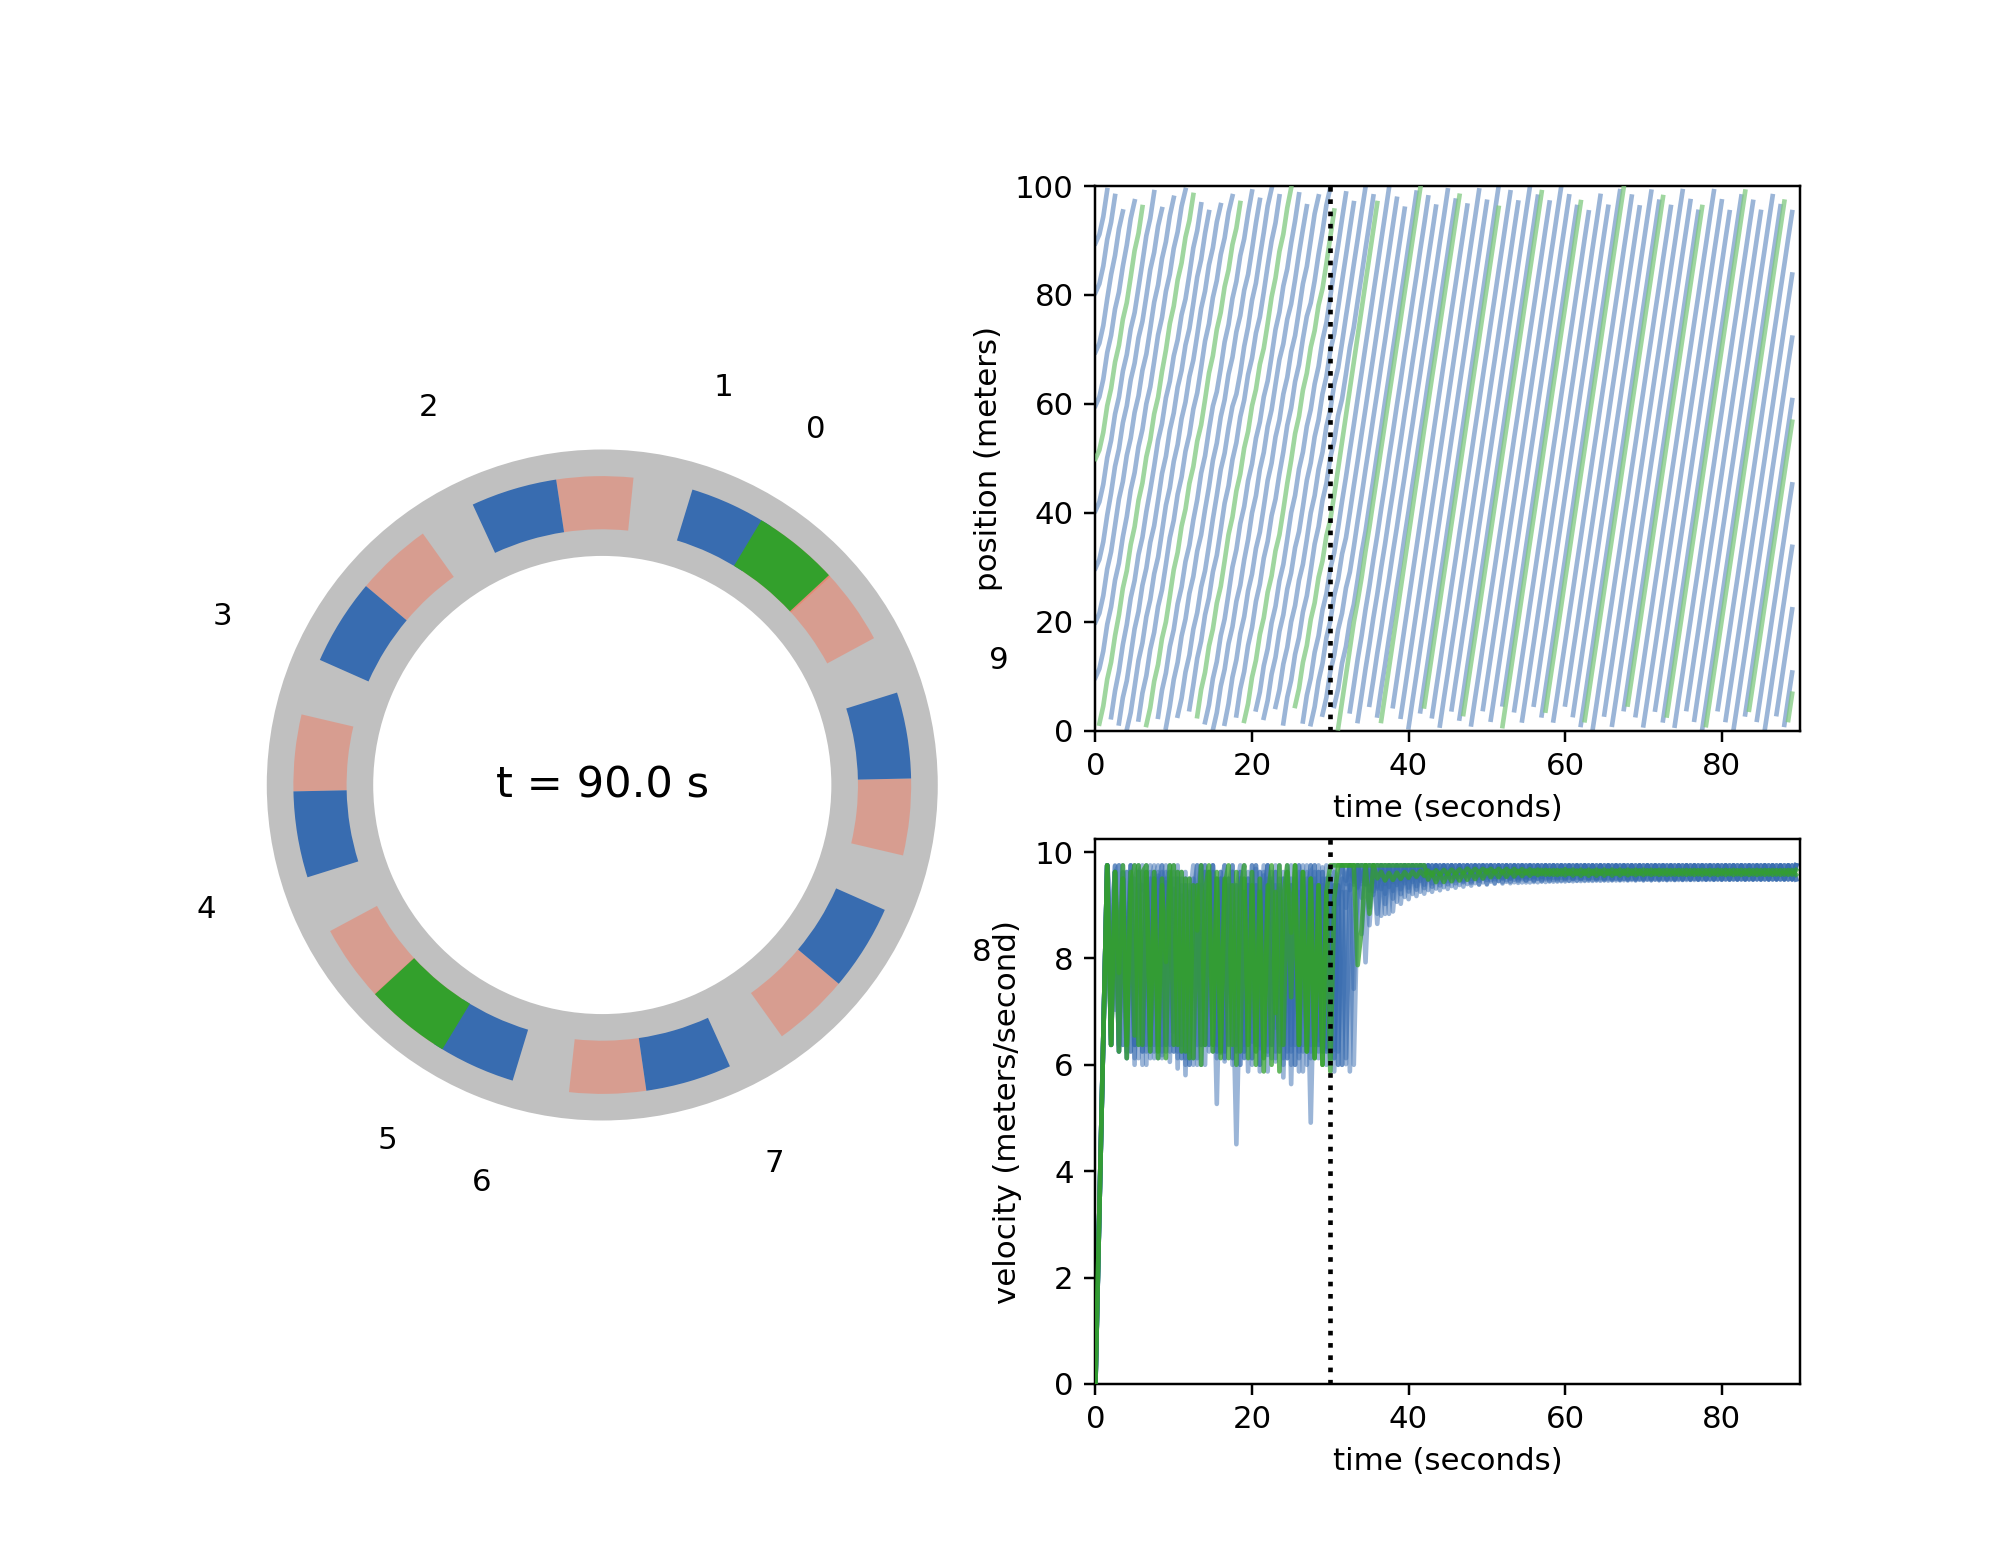

In [6]:
# Define a ring road environment:
road_params = {
    'num_avs' : 2,
    'av_even_spacing' : True,
    'num_vehicles' : 10,  # The vechicles at index 0 is an A.V.
    'ring_length' : 100.0,  # The road is a cicle.
    'starting_noise' : 1.0,  # Uniformly add noise to starting positions.
    'temporal_res' : 0.5,  # Set the size of simulation steps (seconds).
    'av_activate' : 30,  # Set when the PID controller is activated.
    'seed' : 286,  # Set a random seed.
}
road = RingRoad(**road_params)

# Plot initial conditions:
#fig,ax = road.plot_ring(step=0, draw_cars_to_scale=True, draw_safety_buffer=True)

# Run the simulation for set number of time steps:
total_time = 90  # In seconds.
total_steps = int(np.ceil(total_time/road.dt))
road.run(steps=total_steps)

# Show step of simulation:
step = road.step
fig, axs = road.plot_dashboard(
    step=step, total_steps=total_steps,
    draw_cars_to_scale=True, draw_safety_buffer=True, label_step=True, label_cars=True,
)
plt.show()


In [7]:
# # Build animation:
# anim = Animation(road, speedup=5.0, interval=5)
# anim.animate_dashboard(draw_cars_to_scale=True, draw_safety_buffer=False, show_sigma=True)
# anim.stop()

# # Show animation:
# anim.show()

# # Save animation as GIF (may take a few minutes -- pauses preview above):
# anim.save_gif(filepath="../outputs/learning_baseline.gif", overwrite=True)


<a href='https://github.com/chickert/autonomous_vehicles/blob/main/outputs/learning_baseline.gif'><img src='https://github.com/chickert/autonomous_vehicles/raw/main/outputs/learning_baseline.gif' /></a>


# Training:


**Instantiate a `Game` (Reinforcement Learning wrapper for the `RingRoad` class) for the same simulation, but with learning controller:**


In [8]:
# Define the same ring road but with learning mode:
road_params['learning_mode'] = True
road_params['av_activate'] = 0
road = RingRoad(**road_params)

# Initialize a game with this road:
game = Game(
    road = road,
    agent_commands = [-1.0, -0.1, 0.0, 0.1, 1.0],  # Define the possible acceleration commands for each AV.
    past_steps = 3,  # Each 'observation' is the list of positions from the last three time steps.
    max_seconds = None,  # Don't limit the episode length (this will be handles separately in train.py).
)


In [9]:
# Print dimensions of state space and observation space:
print("observation_space shape:",game.observation_space.shape)
print("action_space size:",game.action_space.n)


observation_space shape: (30,)
action_space size: 25


In [10]:
# Print the state space: each 'action' of the RL game corresponds to a list of command (one for each AV):
print(game.action_space())


[(-1.0, -1.0), (-1.0, -0.1), (-1.0, 0.0), (-1.0, 0.1), (-1.0, 1.0), (-0.1, -1.0), (-0.1, -0.1), (-0.1, 0.0), (-0.1, 0.1), (-0.1, 1.0), (0.0, -1.0), (0.0, -0.1), (0.0, 0.0), (0.0, 0.1), (0.0, 1.0), (0.1, -1.0), (0.1, -0.1), (0.1, 0.0), (0.1, 0.1), (0.1, 1.0), (1.0, -1.0), (1.0, -0.1), (1.0, 0.0), (1.0, 0.1), (1.0, 1.0)]


In [11]:
# Example: Get command tuple at given index:
game.action_space.decode(action_index=3)


(-1.0, 0.1)

In [12]:
# Example: Get index of command tuple:
game.action_space.encode(agent_commands=(-1,0))


2

In [13]:
# Example: Take a few steps:
next_observation, reward, done, info = game.step(3)
next_observation, reward, done, info = game.step(0)
next_observation


array([0.997586  , 0.09556007, 0.20421682, 0.30355373, 0.39869693,
       0.5010041 , 0.60154782, 0.70360835, 0.79516076, 0.89511765,
       0.997586  , 0.11181007, 0.22046682, 0.31980373, 0.41494693,
       0.5010041 , 0.61779782, 0.71985835, 0.81141076, 0.91136765,
       0.997586  , 0.14431007, 0.25296682, 0.35230373, 0.44744693,
       0.5012541 , 0.65029782, 0.75235835, 0.84391076, 0.94386765])

In [14]:
# Example: Show states and controls from last few steps:
display(game.road.get_vehicle_pos_table().tail())
display(game.road.get_vehicle_control_table().tail())


,vehicle_id,20,21,22,23,24,25,26,27,28,29
step,time,,,,,,,,,,
0,0.0,99.7586,9.556007,20.421682,30.355373,39.869693,50.10041,60.154782,70.360835,79.516076,89.511765
1,0.5,99.7586,11.181007,22.046682,31.980373,41.494693,50.10041,61.779782,71.985835,81.141076,91.136765
2,1.0,99.7586,14.431007,25.296682,35.230373,44.744693,50.12541,65.029782,75.235835,84.391076,94.386765
3,1.5,99.7586,19.306007,30.171682,40.105373,46.307193,50.12541,69.904782,80.110835,89.266076,95.949265


,vehicle_id,20,21,22,23,24,25,26,27,28,29
step,time,,,,,,,,,,
0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,0.5,0.0,193.296177,184.510992,172.335467,189.066205,0.0,188.775755,153.580762,185.675693,189.248894
2,1.0,-1.0,128.296177,119.510992,107.335467,42.580314,0.1,123.775755,88.580762,120.675693,44.132045
3,1.5,-1.0,63.296177,54.510992,42.335467,-130.219345,-1.0,58.775755,23.580762,55.675693,-130.231668


# Results:


**Load a trained Q-network and use it to run a simulation with the learned controller:**


In [15]:
# Load the saved weights of a trained Q-Network into a Replay
# (wrapper class that queries the Q-network to decide which commands to give the AV):
replay = Replay.from_files(
    saved_models_dir = '../code/dqn/saved-models/',
    run_id = '2m131pjq', ep_num = 2686,
)
replay.build(seconds=27)

q_network = replay.q_network  # Neural net that outputs the Q-value for each action, for a given state.
game = replay.game  # RL game wrapper.
env = replay.game.road  # Ring Road environment.


In [16]:
# Example: Get current game state (position of each vehicle, over last three time steps):
state = replay.game.build_observation()
print("State:", state)

# Example: Query the Q-network to find best action:
state = game.build_observation()  # Returns a state vector.
state = torch.Tensor(state)  # Converts the state vector to a tensor.
q_vals = q_network.forward(state).detach()
action = np.argmax(q_vals.numpy())
print("Recommended action:", action)

# Example: Decode action into command for each of the AVs:
commands = game.action_space.decode(action)
for i,val in enumerate(commands):
    print(f"  Command for AV {i+1} : {val}")


State: [8.78567937e-02 1.68712889e-01 2.56175057e-01 3.53368773e-01
 3.98540152e-01 4.92938040e-01 7.15038457e-01 7.99051985e-01
 8.98483406e-01 2.29586046e-04 1.25106794e-01 1.99962889e-01
 3.03675057e-01 3.67118773e-01 4.14790152e-01 5.12938040e-01
 7.46288457e-01 8.46551985e-01 9.41978025e-01 3.21045860e-02
 1.62356794e-01 2.47462889e-01 3.34300057e-01 3.67118773e-01
 4.47290152e-01 5.35438040e-01 7.93788457e-01 8.77176985e-01
 9.68597643e-01 8.02295860e-02]
Recommended action: 18
  Command for AV 1 : 0.1
  Command for AV 2 : 0.1


Saved : ../outputs/learning_result.gif .


<IPython.core.display.Javascript object>


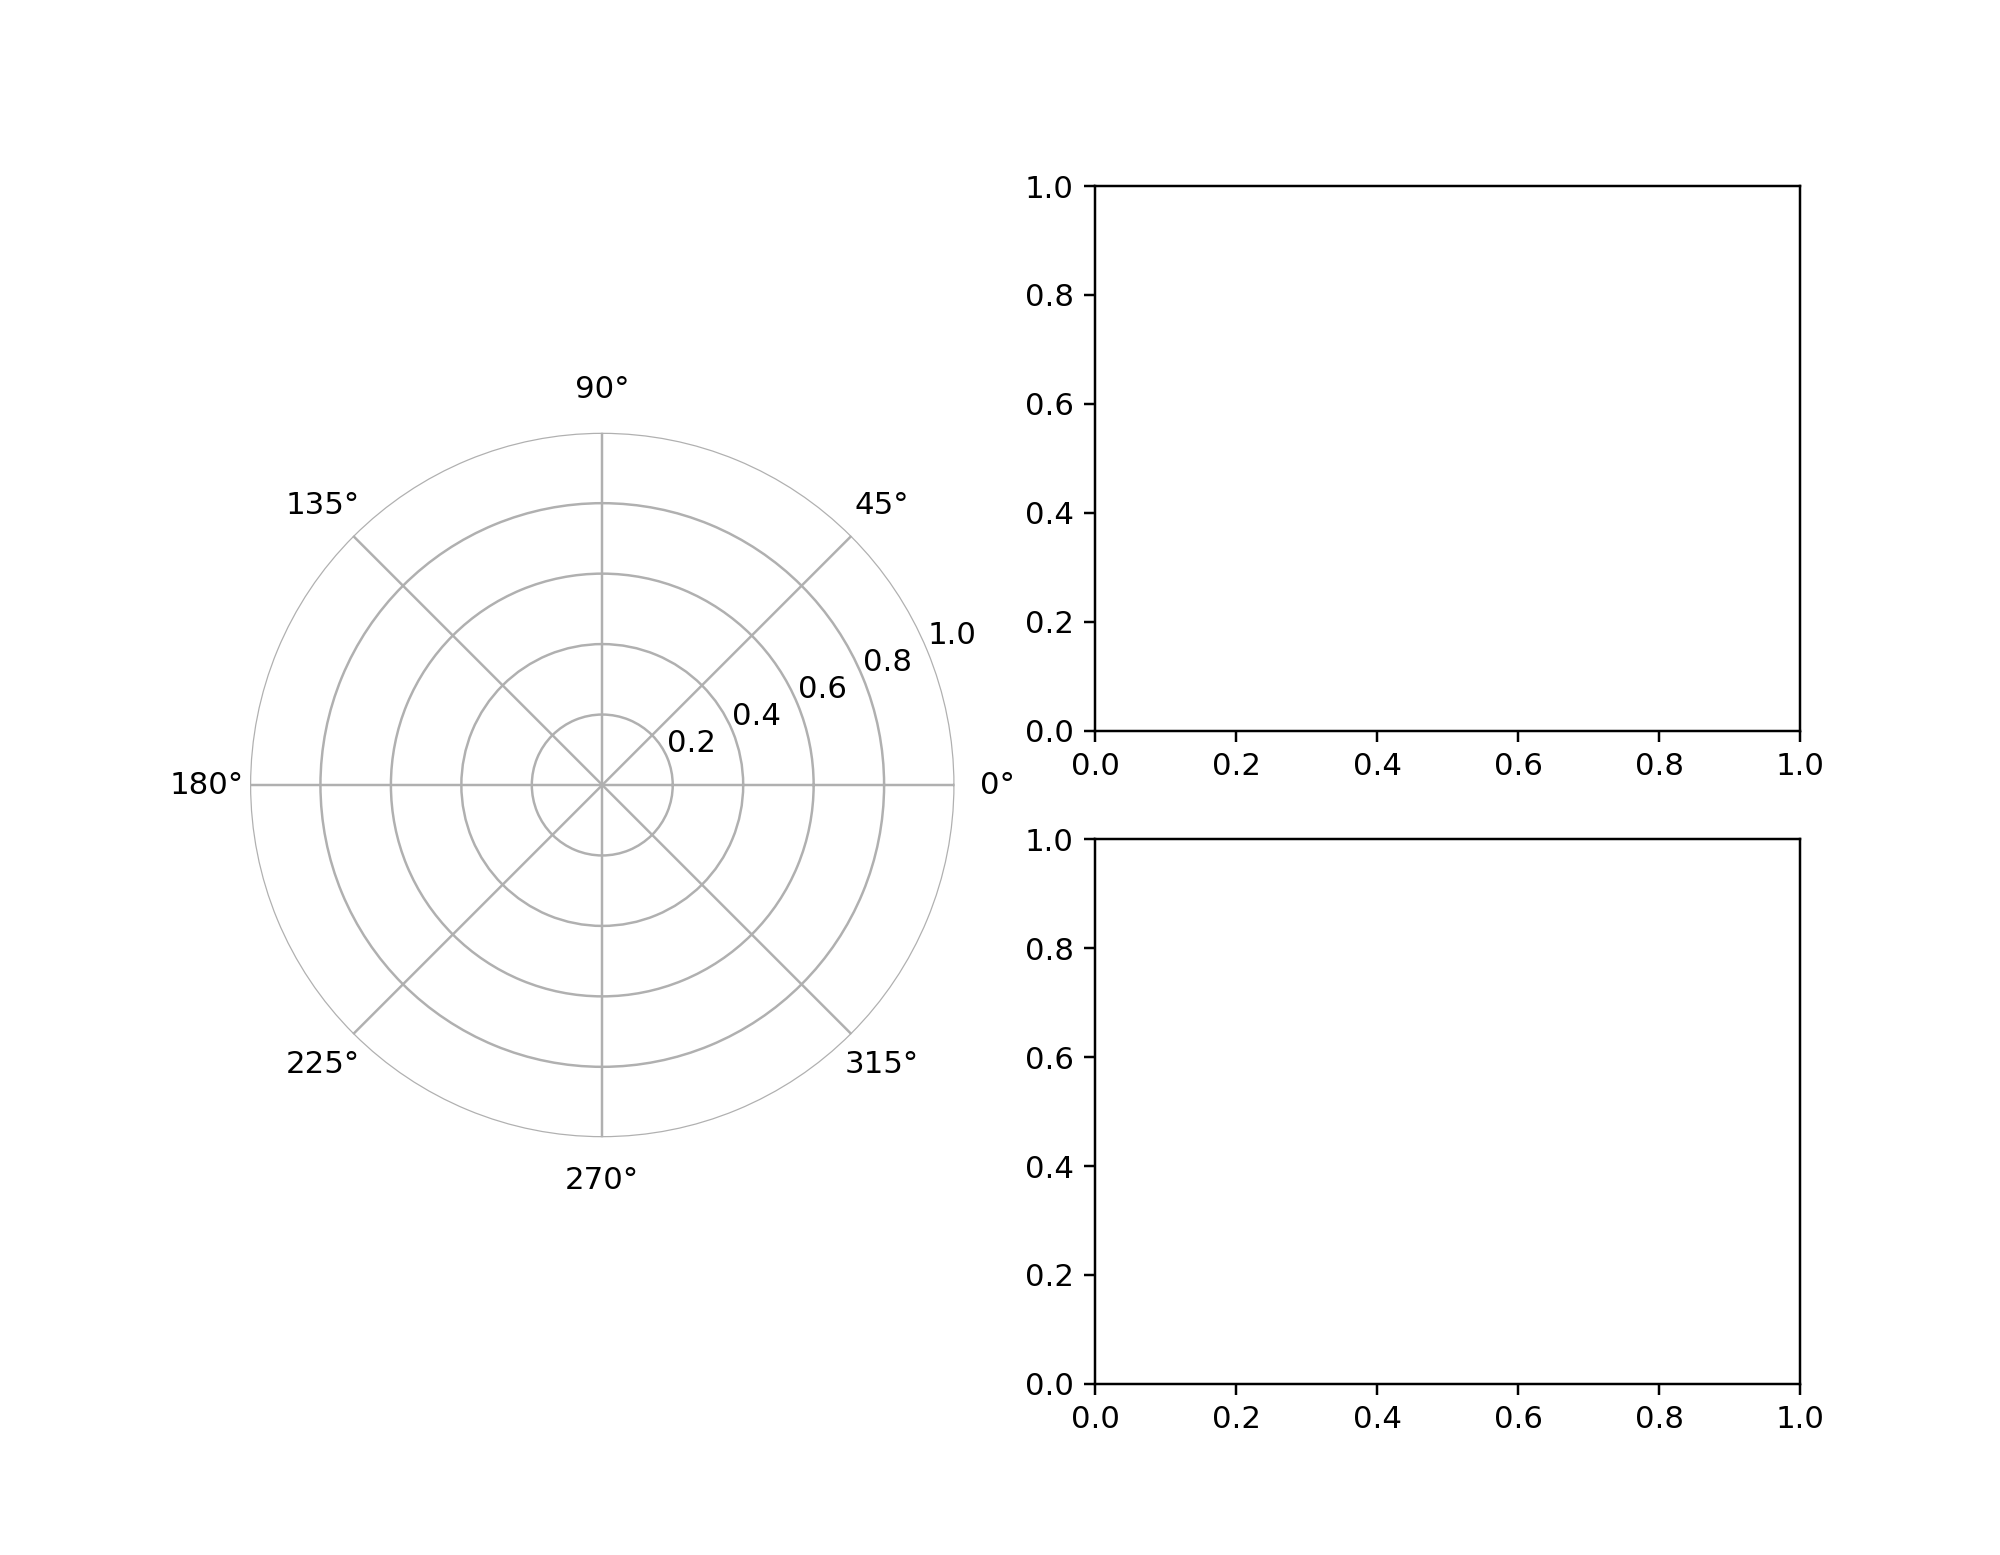

<IPython.core.display.Javascript object>


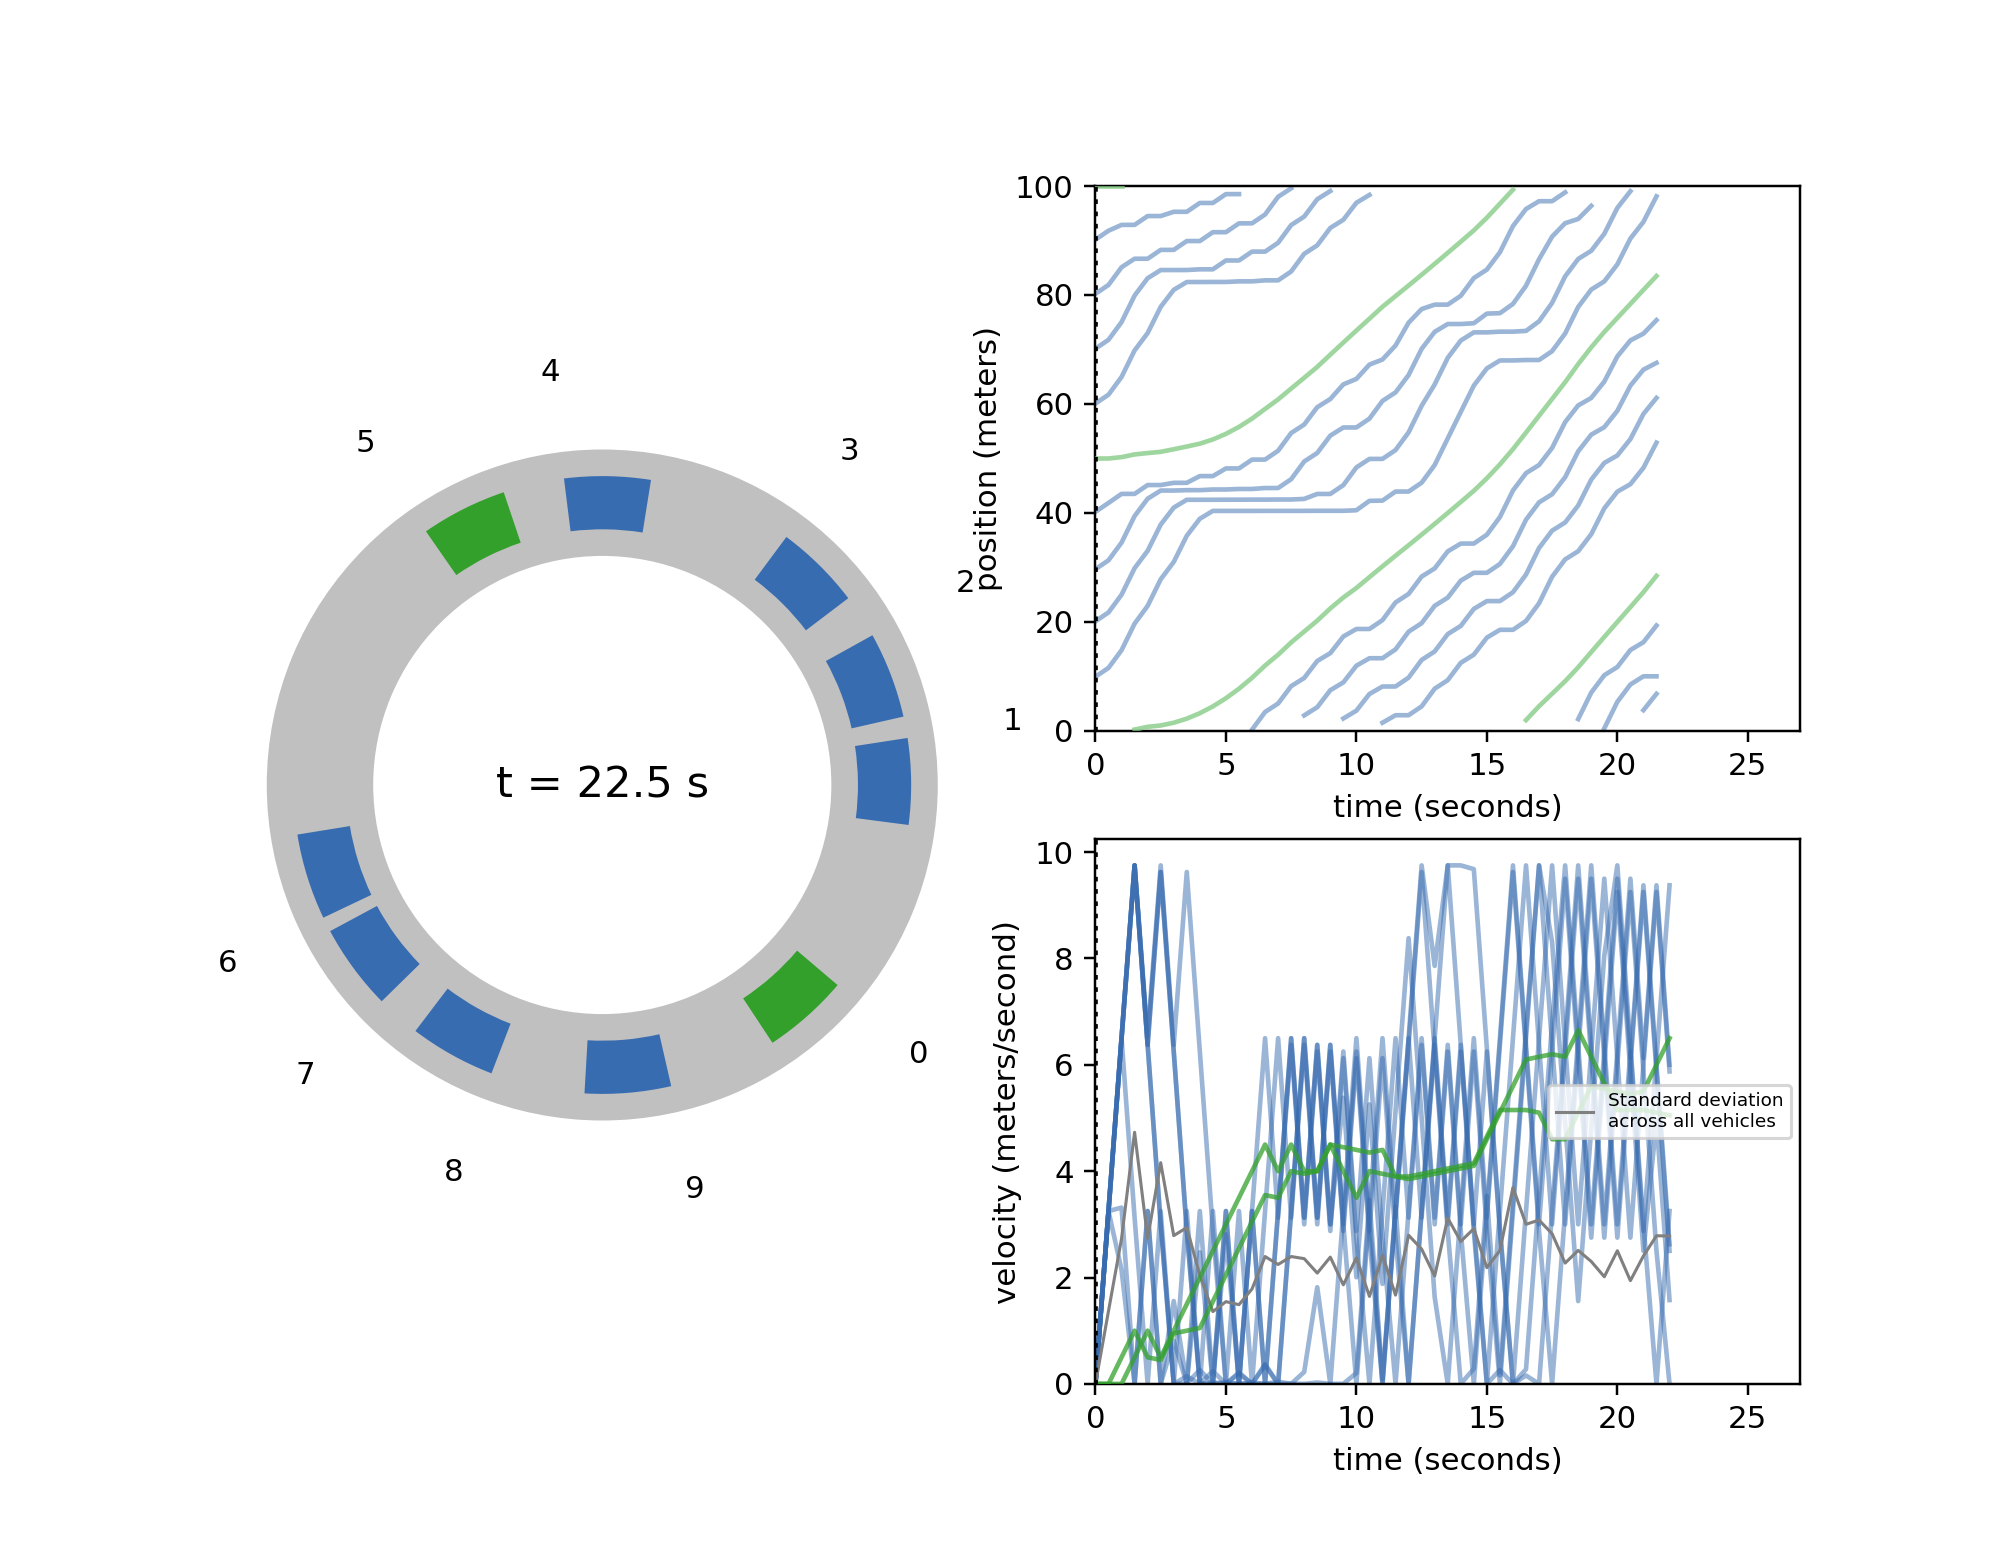

In [17]:
# Build animation:
anim = Animation(env, mode='notebook')
anim.animate_dashboard(draw_cars_to_scale=True, draw_safety_buffer=False, show_sigma=True)
anim.stop()

# Save animation as GIF (may take a few minutes -- pauses preview above):
anim.save_gif(filepath="../outputs/learning_result.gif", overwrite=True)

# Show animation:
anim.show()


<a href='https://github.com/chickert/autonomous_vehicles/blob/main/outputs/learning_result.gif'><img src='https://github.com/chickert/autonomous_vehicles/raw/main/outputs/learning_result.gif' /></a>
